In [2]:
import os
import gc
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms, models
from skimage import transform
from sklearn import model_selection
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from typing import Optional, Sequence

In [3]:
#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda


In [1]:
from ipynb.fs.full import data

cuda


In [4]:
train_dataset = data.TouchDataset(root_dir='Mudra Dataset/Single hand', state='Train', num_classes=160,
                                  transform=transforms.Compose([data.Rescale((227,227)), data.ToTensor()]))
val_dataset = data.TouchDataset(root_dir='Mudra Dataset/Single hand', state='Train', num_classes=160,
                                  transform=transforms.Compose([data.Rescale((227,227)), data.ToTensor()]))
test_dataset = data.TouchDataset(root_dir='Mudra Dataset/Single hand', state='Test', num_classes=160,
                                  transform=transforms.Compose([data.Rescale((227,227)), data.ToTensor()]))

In [5]:
train_loader, valid_loader = data.data_loader(train_dataset, batch_size=32)
test_loader = data.data_loader(test_dataset, batch_size=32, test=True)

In [6]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [57]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [7]:
class AttentionBlock(nn.Module):
    def __init__(self, in_feature_l, in_feature_g, attn_features, up_factor, normalize_attn=True):
        super(AttentionBlock, self).__init__()
        self.up_factor = up_factor
        self.normalize_attn = normalize_attn
        self.W_l = nn.Conv2d(in_channels=in_feature_l, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.W_g = nn.Conv2d(in_channels=in_feature_g, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.phi = nn.Conv2d(in_channels=attn_features, out_channels=1, kernel_size=1, padding=0, bias=True)

    def forward(self, l, g):
        N, C, W, H = l.size()
        l_ = self.W_l(l)
        g_ = self.W_g(g)
        if self.up_factor > 1:
            g_ = F.interpolate(g_, scale_factor=self.up_factor, mode='bilinear', align_corners=False)
        c = self.phi(F.relu(l_ + g_))

        if self.normalize_attn:
            a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,W,H)
        else:
            a = torch.sigmoid(c)

        f = torch.mul(a.expand_as(l), l)

        if self.normalize_attn:
            output = f.view(N,C,-1).sum(dim=2) # weighted sum
        else:
            output = F.adaptive_avg_pool2d(f, (1,1)).view(N,C) # global average pooling
        return a, output

In [59]:
class ResNet(nn.Module):
    def __init__(self, block, layers):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 512)
        #self.fc1 = nn.Linear(512, num_classes)
        #self.fc1.bias = nn.Parameter(initial_bias)
        #self.sig = nn.Sigmoid()
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        #x = self.fc1(x)
        #x = self.sig(x)

        return x

In [17]:
class TouchModel(nn.Module):
    def __init__(self, initial_bias, num_classes, batch_size):
        super(TouchModel, self).__init__()
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.model = ResNet(ResidualBlock, [3,4,6,3])
        self.cl = nn.ModuleList([nn.Linear(self.model.fc.out_features, 1) for i in range(self.num_classes)])
        #for i in range(self.num_classes):
        #    self.cl[i].bias = nn.Parameter(torch.FloatTensor(initial_bias[i]))

        self.sig = nn.Sigmoid()
    
    def forward(self, x):
        res = []
        x = self.model(x)
        for i, l in enumerate(self.cl):
            temp = self.cl[i](x)
            res.append(self.sig(temp))
        return res

In [8]:
class AttnVGG(nn.Module):
    def __init__(self, num_classes, normalize_attn=False, dropout=None):
        super(AttnVGG, self).__init__()
        net = models.vgg16_bn(pretrained=True)
        self.conv_block1 = nn.Sequential(*list(net.features.children())[0:6])
        self.conv_block2 = nn.Sequential(*list(net.features.children())[7:13])
        self.conv_block3 = nn.Sequential(*list(net.features.children())[14:23])
        self.conv_block4 = nn.Sequential(*list(net.features.children())[24:33])
        self.conv_block5 = nn.Sequential(*list(net.features.children())[34:43])
        self.pool = nn.AvgPool2d(7, stride=1)
        self.dpt = None
        if dropout is not None:
            self.dpt = nn.Dropout(dropout)
        #self.cls = nn.Linear(in_features=512+512+256, out_features=num_classes, bias=True)
        self.cl = nn.ModuleList([nn.Linear(in_features=512+512+256, out_features=1, bias=True) for i in range(num_classes)])
        
       # initialize the attention blocks defined above
        self.attn1 = AttentionBlock(256, 512, 256, 4, normalize_attn=normalize_attn)
        self.attn2 = AttentionBlock(512, 512, 256, 2, normalize_attn=normalize_attn)
        self.sig = nn.Sigmoid()
        
       
        #self.reset_parameters(self.cls)
        self.reset_parameters(self.attn1)
        self.reset_parameters(self.attn2)
    def reset_parameters(self, module):
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.)
                nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0., 0.01)
                nn.init.constant_(m.bias, 0.)
    def forward(self, x):
        block1 = self.conv_block1(x)       # /1
        pool1 = F.max_pool2d(block1, 2, 2) # /2
        block2 = self.conv_block2(pool1)   # /2
        pool2 = F.max_pool2d(block2, 2, 2) # /4
        block3 = self.conv_block3(pool2)   # /4
        pool3 = F.max_pool2d(block3, 2, 2) # /8
        block4 = self.conv_block4(pool3)   # /8
        pool4 = F.max_pool2d(block4, 2, 2) # /16
        block5 = self.conv_block5(pool4)   # /16
        pool5 = F.max_pool2d(block5, 2, 2) # /32
        N, __, __, __ = pool5.size()
        
        g = self.pool(pool5).view(N,512)
        a1, g1 = self.attn1(pool3, pool5)
        a2, g2 = self.attn2(pool4, pool5)
        g_hat = torch.cat((g,g1,g2), dim=1) # batch_size x C
        if self.dpt is not None:
            g_hat = self.dpt(g_hat)
        #out = self.cls(g_hat)

        res = []
        for i, l in enumerate(self.cl):
            temp = self.cl[i](g_hat)
            res.append(self.sig(temp))

        return [res, a1, a2]

In [9]:
num_classes = 160
num_epochs = 200
batch_size = 32
learning_rate = 1e-4
initial_bias = []
for i in range(num_classes):
    x = train_dataset.pos[i]/(train_dataset.total - train_dataset.pos[i])
    if x == 0:
        initial_bias.append(0)
    else:
        initial_bias.append(np.log(x))

#touchVGG = VGG16(1)
#model = TouchModel(initial_bias, num_classes, batch_size)
model = AttnVGG(num_classes=160, normalize_attn=True)

#Loss and Optimizer
#criterion = nn.CrossEntropyLoss()
criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

/home/soumen/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/soumen/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
print(np.log(0))

-inf


/tmp/ipykernel_186644/2955966184.py:1: RuntimeWarning: divide by zero encountered in log
  print(np.log(0))


In [ ]:
""" olayer = []
optimizer = []
for i in range(num_classes):
    layer = nn.Sequential(
                nn.Linear(4096, 1))
    model.fc2 = layer
    optimizer.append(torch.optim.Adam(model.parameters(), lr=learning_rate))
    olayer.append(model.fc2) """

In [74]:
def BackPropagationNew(model, images, labels):
    losses = 0.0
    acc = 0
    total = 0
    acc1 = 0
    total1 = 0
    loop = labels.shape[1]
    #Injecting variables into GPU device -- Start
    model = model.to(device)
    images = images.to(device)
    labels = labels.to(device)
    #Injecting variables into GPU device -- End
    
    out, _, _ = model(images)
    #print(out)

    for i in range(loop):
        label = labels[:,i].reshape([labels[:,i].shape[0],1])
        loss = criterion(out[i].type(torch.FloatTensor), label.type(torch.FloatTensor))
        losses += loss
        del loss
        total += 32
        act = labels[:,i]
        pred = out[i].reshape([act.shape[0]])
            
        #print(pred.round())
        #print(act)
        #acc += (pred.round() == act).float().sum()
        for j in range(len(act)):
            if pred[j].round() == act[j]:
                acc += 1
            if act[j] == 1:
                total1 += 1
                if pred[j].round() == act[j]:
                    acc1 += 1
    #label = labels[:,0].reshape([out.shape[0],out.shape[1]])
    #print(label)
    #losses = criterion(out, label)
    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    
    #Releasing variables from GPU device -- Start
    model = model.to('cpu')
    images = images.to('cpu')
    labels = labels.to('cpu')
    #Releasing variables from GPU device -- End
    
    return losses.item(), acc, total, acc1, total1

In [13]:
def calcValLoss(model, name, images, labels):
    losses = 0.0
    acc = 0
    total = 0
    acc1 = 0
    total1 = 0
    noc = labels.shape[1]
    #Injecting variables into GPU device -- Start
    model = model.to(device)
    images = images.to(device)
    labels = labels.to(device)
    #Injecting variables into GPU device -- End

    out,_,_ = model(images)
    for i in range(noc):
        label = labels[:,i].reshape([labels[:,i].shape[0],1])
        loss = criterion(out[i].type(torch.FloatTensor), label.type(torch.FloatTensor))
        losses += loss

        total += 32
        act = labels[:,i]
        pred = out[i].reshape([act.shape[0]])
            
        #print(pred.round())
        #print(act)
        #acc += (pred.round() == act).float().sum()
        for j in range(len(act)):
            if pred[j].round() == act[j]:
                acc += 1
            if act[j] == 1:
                total1 += 1
                if pred[j].round() == act[j]:
                    acc1 += 1
                else:
                    print(name[j], i)
            
    #label = labels[:,0].reshape([out.shape[0],out.shape[1]])
    #losses = criterion(out, label)
    #Releasing variables from GPU device -- Start
    model = model.to('cpu')
    images = images.to('cpu')
    labels = labels.to('cpu')
    #Releasing variables from GPU device -- End
    #del loss
    torch.cuda.empty_cache()
    return losses.item(), acc, total, acc1, total1

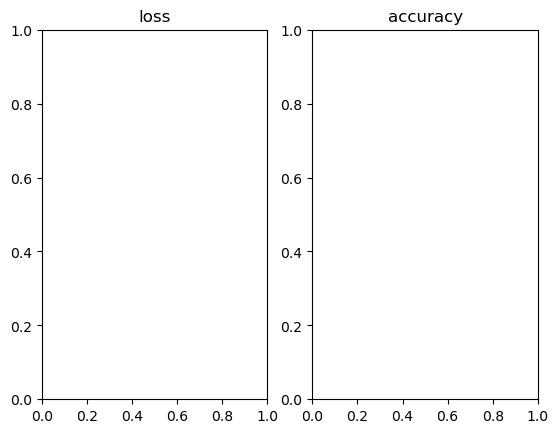

In [76]:
best_loss = float('inf')
early_stop = 15
best_epoch = -1
best_acc = 0.0
y_loss = {} #Loss history
y_acc = {}
y_loss['train'] = []
y_loss['validation'] = []
y_acc['train'] = []
y_acc['validation'] = []
x_epoch = []
fig = plt.figure()
ax0 = fig.add_subplot(121, title="loss")
ax1 = fig.add_subplot(122, title="accuracy")

In [71]:
def draw_curve(current_epoch):
    x_epoch.append(current_epoch)
    #print(x_epoch)
    #print(y_loss['train'])
    ax0.plot(x_epoch, y_loss['train'], color='green', label='train')
    ax0.plot(x_epoch, y_loss['validation'], color='red', label='validation')
    ax1.plot(x_epoch, y_acc['train'], 'green', label='train')
    ax1.plot(x_epoch, y_acc['validation'], 'red', label='validation')
    if current_epoch == 0:
        ax0.legend()
        ax1.legend()
    fig.savefig(os.path.join('train_touch.jpg'))

In [77]:
#Train the model
for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    print('-'*10)
    epochLoss = 0.0
    tacc = 0
    ttotal = 0
    tacc1 = 0
    ttotal1 = 0
    print(len(train_loader))
    for i, sample in enumerate(train_loader):
        images = sample['image']
        labels = sample['label']
        #print(labels[:,0])

        loss, a, t, a1, t1 = BackPropagationNew(model, images, labels)
        epochLoss += loss
        tacc += a
        ttotal += t
        tacc1 += a1
        ttotal1 += t1

    if total1 > 0:
        x = tacc1/ttotal1
    else:
        x = 0
        
        #print('Step {}/{}'.format(i+1, len(train_loader)))

    print('Epoch [{}/{}], Step [{}/{}]'.format(epoch+1, num_epochs, i+1, len(train_loader)))
    print(f"Train Loss at epoch {epoch+1} || {epochLoss/len(train_loader)}")
    print(f"Training accuracy: {tacc/ttotal}, {x}")
    y_acc['train'].append(x)
    x = epochLoss/len(train_loader)
    
    #print(x.is_cuda)
    y_loss['train'].append(x)
    #scheduler.step()

    #Validation 
    val_loss = 0.0
    vacc = 0
    vtotal = 0
    vacc1 = 0
    vtotal1 = 0
    with torch.no_grad():
        for i, sample in enumerate(valid_loader):
            images = sample['image']
            labels = sample['label']

            loss, a, t, a1, t1 = calcValLoss(model, images, labels)
            val_loss += loss
            vacc += a
            vtotal += t
            vacc1 += a1
            vtotal1 += t1

        if total1 > 0:
            x = vacc1/vtotal1
        else:
            x = 0

        if x > best_acc:
            best_acc = x
            best_epoch = epoch
            torch.save(model.state_dict(), "touch_model.pth")
            print("Model summary saved...")
        elif epoch - best_epoch > early_stop:
            print("Early stopped training at epoch %d" % epoch)
            break
        
        
        print(f"Validation loss for epoch {epoch+1} || {val_loss/len(valid_loader)}") 
        print(f"Validation accuracy: {vacc/vtotal}, {x}")
        y_acc['validation'].append(x)
        x = val_loss/len(valid_loader)
        y_loss['validation'].append(x)

        draw_curve(epoch)
    
    model.load_state_dict(torch.load("touch_model.pth"))

----------
294
Epoch [1/200], Step [294/294]
Train Loss at epoch 1 || 0.5036181093377321
Training accuracy: 0.9844660129676871, 0.3193693350597913
Validation loss for epoch 1 || 0.13404480909759348
Validation accuracy: 0.9827414772727273, 0.5621428571428572
----------
294
Epoch [2/200], Step [294/294]
Train Loss at epoch 2 || 0.08255616970816437
Training accuracy: 0.9950926073554421, 0.756797928250438
Validation loss for epoch 2 || 0.05725538019429554
Validation accuracy: 0.9858487215909091, 0.8335714285714285
----------
294
Epoch [3/200], Step [294/294]
Train Loss at epoch 3 || 0.031604873897114985
Training accuracy: 0.997011187287415, 0.9288597760682459
Validation loss for epoch 3 || 0.028178057210011917
Validation accuracy: 0.9869199810606061, 0.9428571428571428
----------
294
Epoch [4/200], Step [294/294]
Train Loss at epoch 4 || 0.013244122279440464
Training accuracy: 0.9976057610544218, 0.9781399954299642
Validation loss for epoch 4 || 0.015429907097396526
Validation accuracy: 0.

In [17]:
model.load_state_dict(torch.load("/home/soumen/Soumen/2nd/Touch model/touch_model_final.pth"))

<All keys matched successfully>

In [26]:
val_loss = 0
vacc = 0
vtotal = 0
vacc1 = 0
vtotal1 = 0
all_dataset = data.TouchDataset(root_dir='Mudra Dataset/Single hand', num_classes=160,
                                  transform=transforms.Compose([data.Rescale((227,227)), data.ToTensor()]))
print(len(all_dataset))
loader = data.data_loader(all_dataset, batch_size=1, test=True)
with torch.no_grad():
    for i, sample in enumerate(loader):
        images = sample['image']
        labels = sample['label']
        name = sample['name']
        #print(images.shape)
        loss, a, t, a1, t1 = calcValLoss(model, name, images, labels)
        val_loss += loss
        vacc += a
        vtotal += t
        vacc1 += a1
        vtotal1 += t1

    if vtotal1 > 0:
        x = vacc1/vtotal1
    else:
        x = 0
    print(f"Test loss {val_loss/len(test_loader)}") 
    print(f"Test accuracy: {vacc/vtotal}, {x}, {vacc1}/{vtotal1}")

13908


/home/soumen/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Mudra Dataset/Single hand/Simhamukha/240.jpg 35
Mudra Dataset/Single hand/Simhamukha/240.jpg 39
Mudra Dataset/Single hand/Shikhara/350.jpg 0
Mudra Dataset/Single hand/Kartarimukha/282.jpg 42
Mudra Dataset/Single hand/Mrigashirsha/441.jpg 17
Mudra Dataset/Single hand/Trishula/477.jpg 52
Mudra Dataset/Single hand/Trishula/2.jpg 52
Mudra Dataset/Single hand/Mushthi/4.jpg 34
Mudra Dataset/Single hand/Mushthi/4.jpg 38
Mudra Dataset/Single hand/Mushthi/77.jpg 34
Mudra Dataset/Single hand/Mushthi/77.jpg 38
Mudra Dataset/Single hand/Shukatunda/144.jpg 49
Mudra Dataset/Single hand/Mrigashirsha/529.jpg 17
Mudra Dataset/Single hand/Hamsapaksha/382.jpg 34
Mudra Dataset/Single hand/Simhamukha/145.jpg 35
Mudra Dataset/Single hand/Simhamukha/145.jpg 39
Mudra Dataset/Single hand/Hamsapaksha/349.jpg 34
Mudra Dataset/Single hand/Mayura/331.jpg 60
Mudra Dataset/Single hand/Suchi/381.jpg 34
Mudra Dataset/Single hand/Kapitta/54.jpg 51
Mudra Dataset/Single hand/Ardhapataaka/326.jpg 0
Mudra Dataset/Single ha